<a href="https://colab.research.google.com/github/JakobRobnik/periodax/blob/master/tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this tutorial we will explore how the `periodax` package works. We will start with the standard Lomb-Scargle periodogram to get familiar with the syntax. Then we will show how to
- do roboust p-value calculation
- do periodogram in the presence of correlated Gaussian noise
- go beyond the likelihood-ratio test statistic and compute the Bayes factor

First, let's clone the package from github:

In [1]:
!git clone https://github.com/JakobRobnik/periodax.git

fatal: destination path 'periodax' already exists and is not an empty directory.


And do some imports:

In [6]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from periodax.LombScargle.periodogram import lomb_scargle, randomized_period

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

The package relies on Jax, for more information see [here](https://jax.readthedocs.io/en/latest/notebooks/quickstart.html). The syntax is essentially that of NumPy.

# Lomb-Scargle periodogram

Let's simulate some simple data:

In [7]:
time = jnp.arange(100) #equally spaced time series

# noise
rng_key = jax.random.PRNGKey(42)
key_err, key_noise = jax.random.split(rng_key)
err = jnp.abs(jax.random.normal(key_err, shape = time.shape)) # randomly generate some errorbars
noise = jax.random.normal(key_noise, shape = time.shape) * err # independent Gaussian noise with the given errorbars

# inject some signal
period = 11. # injected period of the signal
signal = jnp.sin(0.4 + 2 * jnp.pi * time / period) * 0.12
data = noise + signal

And visualize it:

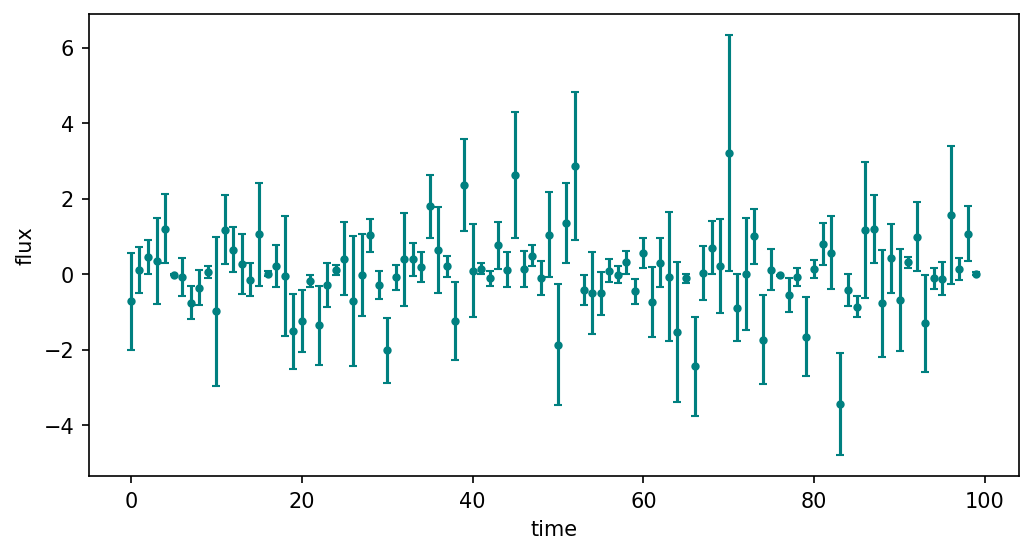

In [8]:
plt.errorbar(time, data, yerr= err, fmt = '.', capsize = 2., color = 'teal')
plt.xlabel('time')
plt.ylabel('flux')
plt.show()

Let's pass the data to `periodax`, which gives us a function for computing the periodogram:

In [4]:
compute_periodogram = lomb_scargle(time, data, floating_mean= True, sqrt_cov= err)


`sqrt_cov` is the square root of the covariance matrix. If noise is uncorrelated these are simply data errors. We will say more about this later.

We would now like to compute the periodogram on a grid of trial frequencies:

In [5]:
freq = jnp.arange(1, len(time)//2) / len(time) # 1/T, 2/T, ... Nyquist frequency

In Jax this operation can easily be parallelized with `jax.vmap` or `jax.pmap`, we will here use `vmap` because this operation is not expensive and we are using a single device:

In [6]:
parallelized_compute_periodogram = jax.vmap(compute_periodogram)

Let's compute the periodogram:

In [7]:
score, amp = parallelized_compute_periodogram(freq)

The output are the periodogram scores at each frequency ($\chi^2$ at the optimal amplitudes) and the optimal amplitudes.

Let's visualize the results:

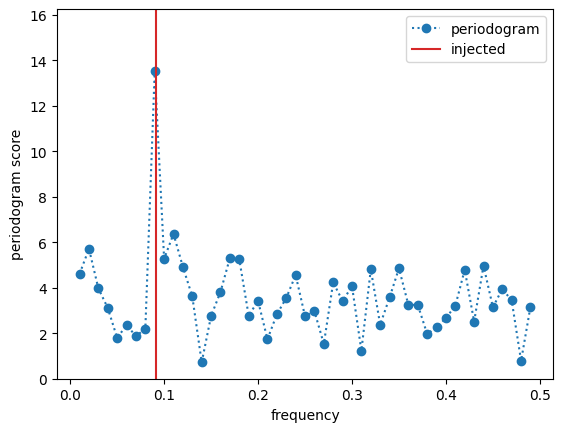

In [67]:
plt.plot(freq, score, 'o:', label = 'periodogram')
plt.plot(jnp.ones(2) / period, [0., jnp.max(score) * 2], '-', color = 'tab:red', label = 'injected')
plt.legend()
plt.xlabel('frequency')
plt.ylabel('periodogram score')
plt.ylim(0, jnp.max(score) * 1.2)
plt.show()

The injected frequency was correctly retrieved.

# Roboust p-value

Naturally we would now like to know if our detection is significant or is it just a consequence of the lookelsewhere effect.

In [55]:
max_number_periods = (int)(2 * freq[-1] * (jnp.max(time) - jnp.min(time))) # factor of two is just to be sure

def sim(key):
    temp = randomized_period(key, max_number_periods, 0.2)
    score, _ = jax.vmap(lomb_scargle(time, data, floating_mean= True, sqrt_cov= err, temp_func= temp))(freq)
    return jnp.max(score)

key_template = jax.random.PRNGKey(43)
num_sim = 10000
score_null = jax.vmap(sim)(jax.random.split(key_template, num_sim))

In [10]:
def cdf_with_err(x_given, sgn = -1):
    """compute cdf and determine the errors by bootstrap"""
    key = jax.random.PRNGKey(0)

    repeat = 100

    #sigma          1         2      3
    #percentiles = 34.1     47.7    49.8
    percentile = 34.1
    ilow = (int) (repeat * (50 - percentile) / 100)
    ihigh = (int)(repeat * (50 + percentile) / 100)

    x = sgn*jnp.sort(sgn*x_given)
    num_realizations = len(x)
    pMC = (jnp.arange(num_realizations) + 1.0) / (num_realizations + 1.0)

    index = jax.random.randint(key, minval = 0, maxval = num_realizations, shape = (repeat, num_realizations))
    #X = x[index]
    X = sgn*jnp.sort(jnp.sort(sgn*x[index], axis = 1), axis = 0)

    return pMC, x, X[ilow, :], X[ihigh, :]

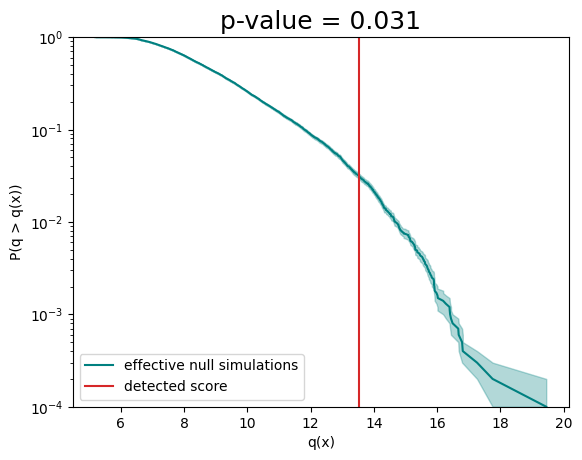

In [68]:
cdf, x, xmin, xmax = cdf_with_err(score_null)

plt.plot(x, cdf, color = 'teal', label = 'effective null simulations')
plt.fill_betweenx(cdf, xmin, xmax, color = 'teal', alpha= 0.3)
best_score = jnp.max(score)
pval = cdf[jnp.searchsorted(-x, -best_score)]
plt.title('p-value = {0:.2}'.format(pval), fontsize = 18)
plt.plot([best_score, best_score], [1e-4, 1], color = 'tab:red', label= 'detected score')
plt.yscale('log')
plt.xlabel('q(x)')
plt.ylabel('P(q > q(x))')
plt.ylim(1e-4, 1.)
plt.legend()
plt.show()

Note that in this syntethic example we know how to simulate the data and we could have just done the real simulations, with the same result

In [57]:
def real_sim(key):
    sim_data = jax.random.normal(key, shape = time.shape) * err # independent Gaussian noise with the given errorbars
    score, _ = jax.vmap(lomb_scargle(time, sim_data, sqrt_cov= err, floating_mean= True))(freq)
    return jnp.max(score)

key_data = jax.random.PRNGKey(44)
score_real_sim = jax.vmap(real_sim)(jax.random.split(key_template, num_sim))

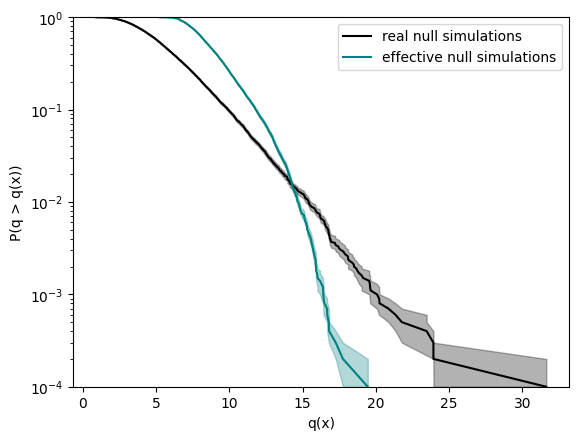

In [70]:
cdf2, x2, xmin2, xmax2 = cdf_with_err(score_real_sim)

plt.plot(x2, cdf2, color = 'black', label = 'real null simulations')
plt.fill_betweenx(cdf2, xmin2, xmax2, color = 'black', alpha= 0.3)

plt.plot(x, cdf, color = 'teal', label = 'effective null simulations')
plt.fill_betweenx(cdf, xmin, xmax, color = 'teal', alpha= 0.3)

plt.yscale('log')
plt.xlabel('q(x)')
plt.ylabel('P(q > q(x))')
plt.ylim(1e-4, 1.)
plt.legend()
plt.show()

In realistic situations we often do not know how to simulate the data, but the method presented here is still applicable.

# Correlated Gaussian noise

# Bayes factor